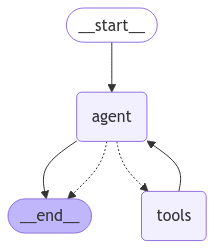

In [1]:
from dotenv import load_dotenv
from typing import List, Dict
from langchain_core.tools import tool
from langchain_core.messages import AIMessage
from langchain_experimental.tools import PythonAstREPLTool
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

import sys
sys.path.append('../..')
from agent_tools.custom_tools import search_news as search_news_


@tool
def search_news(query:str) -> List[Dict[str, str]]:
    """Search Naver News by input keyword"""
    return [
        {
            "url": item["link"],
            "content": item["content"]
        } for item in search_news_.invoke(query)[:5]
    ]


@tool
def python_code_interpreter(code: str):
    """Call to excute python code"""
    return PythonAstREPLTool().invoke(code)


load_dotenv()
tools = [search_news, python_code_interpreter]
tool_node = ToolNode(tools)
model_with_tools = ChatOpenAI(model='gpt-4o-mini', temperature=0).bind_tools(tools)


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", tools_condition)
workflow.add_edge("tools", "agent")
workflow.add_edge("agent", END)

app = workflow.compile()

display(Image(app.get_graph(xray=True).draw_mermaid_png()))


### Agent

In [2]:
# python code
for chunk in app.stream(
    {"messages": [("human", "처음 5개의 소수를 출력하는 python code 를 작성해줘")]},
    stream_mode="values"
):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

처음 5개의 소수를 출력하는 python code 를 작성해줘
================================== Ai Message ==================================
Tool Calls:
  python_code_interpreter (call_tsOorBcNq7FQlt6dOLV8070R)
 Call ID: call_tsOorBcNq7FQlt6dOLV8070R
  Args:
    code: def first_n_primes(n):
    primes = []
    num = 2  # Starting from the first prime number
    while len(primes) < n:
        is_prime = True
        for i in range(2, int(num**0.5) + 1):
            if num % i == 0:
                is_prime = False
                break
        if is_prime:
            primes.append(num)
        num += 1
    return primes

# Get the first 5 prime numbers
first_n_primes(5)
================================= Tool Message =================================
Name: python_code_interpreter

[2, 3, 5, 7, 11]
================================== Ai Message ==================================

처음 5개의 소수는 다음과 같습니다: [2, 3, 5, 7, 11]


In [3]:
# 기사 검색
for chunk in app.stream(
    {"messages": [("human", "search naver news about AI")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

search naver news about AI
================================== Ai Message ==================================
Tool Calls:
  search_news (call_Lr2q258W57P2N2XPQUgXLFYT)
 Call ID: call_Lr2q258W57P2N2XPQUgXLFYT
  Args:
    query: AI
================================= Tool Message =================================
Name: search_news

[{"url": "https://n.news.naver.com/mnews/article/008/0005142434?sid=100", "content": "[단독]\"AI 교과서 지위유지\" 교육감들 입장문, 전국 교육청 절반 이상 \"몰랐다\""}, {"url": "https://n.news.naver.com/mnews/article/003/0013021600?sid=101", "content": "씨어스테크놀로지, GAC서 AI 헬스케어 기기 공개"}, {"url": "https://n.news.naver.com/mnews/article/018/0005927114?sid=101", "content": "머스크 AI개발사 납품 소식에…LS그룹주 급등[특징주]"}, {"url": "https://n.news.naver.com/mnews/article/001/0015165926?sid=102", "content": "강기정 광주시장, 최상목 대행에 AI 2단계 예타 면제 요청"}, {"url": "https://n.news.naver.com/mnews/article/001/0015164855?sid=105", "content": "한국IBM, 

In [4]:
# 도구 호출이 필요 없는 질문 수행
for chunk in app.stream(
    {"messages": [("human", "안녕? 반가워")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

안녕? 반가워
================================== Ai Message ==================================

안녕하세요! 반갑습니다. 어떻게 도와드릴까요?


### ToolNode 수동 호출

In [5]:

def test_single_tool_call():
    message_with_single_tool_call = AIMessage(
        content="",
        tool_calls=[
            {
                "name": "search_news",
                "args": {"query": "AI"},
                "id": "tool_call_id",
                "type": "tool_call"
            }
        ]
    )
    response = tool_node.invoke({"messages": [message_with_single_tool_call]})
    return response

def test_multiple_tool_call():
    message_with_multiple_tool_calls = AIMessage(
        content="",
        tool_calls=[
            {
                "name": "search_news",
                "args": {"query": "AI"},
                "id": "tool_call_id",
                "type": "tool_call",
            },
            {
                "name": "python_code_interpreter",
                "args": {"code": "print(1+2+3+4)"},
                "id": "tool_call_id",
                "type": "tool_call",
            },
        ],
    )

    response = tool_node.invoke({"messages": [message_with_multiple_tool_calls]})
    return response


In [6]:
test_single_tool_call()


{'messages': [ToolMessage(content='[{"url": "https://n.news.naver.com/mnews/article/008/0005142434?sid=100", "content": "[단독]\\"AI 교과서 지위유지\\" 교육감들 입장문, 전국 교육청 절반 이상 \\"몰랐다\\""}, {"url": "https://n.news.naver.com/mnews/article/003/0013021600?sid=101", "content": "씨어스테크놀로지, GAC서 AI 헬스케어 기기 공개"}, {"url": "https://n.news.naver.com/mnews/article/018/0005927114?sid=101", "content": "머스크 AI개발사 납품 소식에…LS그룹주 급등[특징주]"}, {"url": "https://n.news.naver.com/mnews/article/001/0015165926?sid=102", "content": "강기정 광주시장, 최상목 대행에 AI 2단계 예타 면제 요청"}, {"url": "https://n.news.naver.com/mnews/article/001/0015164855?sid=105", "content": "한국IBM, 노동부 주관 AI 전문 인재 양성 사업 참여"}]', name='search_news', tool_call_id='tool_call_id')]}

In [7]:
test_multiple_tool_call()


{'messages': [ToolMessage(content='[{"url": "https://n.news.naver.com/mnews/article/008/0005142434?sid=100", "content": "[단독]\\"AI 교과서 지위유지\\" 교육감들 입장문, 전국 교육청 절반 이상 \\"몰랐다\\""}, {"url": "https://n.news.naver.com/mnews/article/003/0013021600?sid=101", "content": "씨어스테크놀로지, GAC서 AI 헬스케어 기기 공개"}, {"url": "https://n.news.naver.com/mnews/article/018/0005927114?sid=101", "content": "머스크 AI개발사 납품 소식에…LS그룹주 급등[특징주]"}, {"url": "https://n.news.naver.com/mnews/article/001/0015165926?sid=102", "content": "강기정 광주시장, 최상목 대행에 AI 2단계 예타 면제 요청"}, {"url": "https://n.news.naver.com/mnews/article/001/0015164855?sid=105", "content": "한국IBM, 노동부 주관 AI 전문 인재 양성 사업 참여"}]', name='search_news', tool_call_id='tool_call_id'),
  ToolMessage(content='10\n', name='python_code_interpreter', tool_call_id='tool_call_id')]}

### LLM + 도구

In [8]:
# 도구 호출 확인
model_with_tools.invoke("처음 5개의 소수를 출력하는 python code 를 작성해줘").tool_calls


[{'name': 'python_code_interpreter',
  'args': {'code': 'def first_n_primes(n):\n    primes = []\n    num = 2  # Starting from the first prime number\n    while len(primes) < n:\n        is_prime = True\n        for i in range(2, int(num**0.5) + 1):\n            if num % i == 0:\n                is_prime = False\n                break\n        if is_prime:\n            primes.append(num)\n        num += 1\n    return primes\n\n# Get the first 5 prime numbers\nfirst_n_primes(5)'},
  'id': 'call_JDDReTwkEzG3RfZLJZanpzC2',
  'type': 'tool_call'}]

In [9]:
# 도구 노드를 통한 메시지 처리 및 LLM 모델의 도구 기반 응답 생성
tool_node.invoke(
    {
        "messages": [
            model_with_tools.invoke(
                "처음 5개의 소수를 출력하는 python code 를 작성해줘"
            )
        ]
    }
)


{'messages': [ToolMessage(content='[2, 3, 5, 7, 11]', name='python_code_interpreter', tool_call_id='call_zHuZ4kgeoEFznzXUgph2bsoR')]}

### TypedDict 관련

In [11]:
from typing import NotRequired
from langgraph.graph import MessagesState

class State1(MessagesState, total=False):
    dummy1: str

class State2(MessagesState):
    dummy2: NotRequired[str]


State1.__required_keys__, State2.__required_keys__


(frozenset({'messages'}), frozenset({'messages'}))

In [12]:
State1.__optional_keys__, State2.__optional_keys__


(frozenset({'dummy1'}), frozenset({'dummy2'}))